In [2]:
import copy
import time
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.datasets as datasets
import torchvision.models as models
from torchvision import transforms
import torch.optim as optim
import time
from tqdm import tqdm, trange

import loss_landscapes
import loss_landscapes.metrics

In [2]:
transform = transforms.Compose([transforms.ToTensor(),transforms.Lambda(lambda x: x.repeat(3, 1, 1)),]) 
batch_size = 256

# download dataset
mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
print(len(mnist_train), len(mnist_test))

# Load dataset
train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size, shuffle=True, num_workers=0)

60000 10000


# Define ResNet

In [3]:
class ResNetFeatrueExtractor18(nn.Module):
    def __init__(self, pretrained = True):
        super(ResNetFeatrueExtractor18, self).__init__()
        model_resnet18 = models.resnet18(pretrained=pretrained)
        self.conv1 = model_resnet18.conv1
        self.bn1 = model_resnet18.bn1
        self.relu = model_resnet18.relu
        self.maxpool = model_resnet18.maxpool
        self.layer1 = model_resnet18.layer1
        self.layer2 = model_resnet18.layer2
        self.layer3 = model_resnet18.layer3
        self.layer4 = model_resnet18.layer4
        self.avgpool = model_resnet18.avgpool

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)

        return x

class ResClassifier(nn.Module):
    def __init__(self, dropout_p=0.5): #in_features=512
        super(ResClassifier, self).__init__()        
        self.fc = nn.Linear(512, 10)
    def forward(self, x):       
        out = self.fc(x)
        return out

In [4]:
netG = ResNetFeatrueExtractor18(pretrained = False)
netF = ResClassifier()

/global/homes/g/geshi/.conda/envs/CRF_GPU_Env/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/global/homes/g/geshi/.conda/envs/CRF_GPU_Env/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


# Load pretrained ResNet

In [5]:
PATH = '/global/u2/g/geshi/loss-landscapes-tda-dev/loss-landscapes/models/mnist_resnet18.pt'
netG.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [6]:
for param in netG.parameters():
    param.requires_grad = False

In [7]:
if torch.cuda.is_available():
    netG = netG.cuda()
    netF = netF.cuda()

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(netF.parameters(), lr=0.01, momentum=0.9, weight_decay=0.001)

# Fine tune and test pretrained model

In [9]:
def fine_tune_train(netG, netF, train_loader, criterion, optimizer, num_epochs=25):
    since = time.time()
    netG.train()
    netF.train()
    pbar = trange(num_epochs, desc='Epoch', unit='epoch', position=0)
    for epoch in pbar:
        
        running_loss = 0.0
        running_corrects = 0
        count = 0
        piter = tqdm(train_loader, desc='Batch', unit='batch', position=1, leave=False)
        for inputs, labels in piter:
            
            # train on GPU if possible  
            if torch.cuda.is_available():
                inputs = inputs.cuda()
                labels = labels.cuda()
            count += inputs.size(0)

            optimizer.zero_grad()

            # extracted feature
            extractor = netG(inputs)     
            # predicted labels
            outputs = netF(extractor)
            _, preds = torch.max(outputs, 1)

            # loss function
            loss= criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            
        epoch_loss = running_loss / count
        epoch_acc = running_corrects.double() / count
        pbar.set_postfix(loss = epoch_loss, acc=100. * epoch_acc)
        # print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f, time %.1f sec'\
        #     % (epoch + 1, train_l_sum/n, train_acc_sum/n, test_acc, time.time() - start))

In [10]:
fine_tune_train(netG, netF, train_loader, criterion, optimizer, num_epochs=2)

Epoch: 100%|██████████| 2/2 [00:12<00:00,  6.24s/epoch, acc=tensor(99.8733, device='cuda:0', dtype=torch.float64), loss=0.00458]


In [11]:
def test_accuracy(test_loader, netG, netF):
    """Evaluate testset accuracy of a model."""
    netG.eval()
    netF.eval()
    acc_sum, count = 0, 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            # send data to the GPU if cuda is availabel
            if torch.cuda.is_available():
                inputs = inputs.cuda()
                labels = labels.cuda()
            count += inputs.size(0)
            
            outputs = netF(netG(inputs))
            _, preds = torch.max(outputs, 1)

            # labels = labels.long()
            acc_sum += torch.sum(preds == labels.data).item()
    return acc_sum/count

In [12]:
since = time.time()
acc = test_accuracy(test_loader, netG, netF)
print('time cost ', time.time()-since)
print(acc)

time cost  0.9359967708587646
0.9894


# Ensemble model

In [13]:
class ResNet20(nn.Module):
    def __init__(self, extractor, classifier):
        super(ResNet20, self).__init__()
        self.extractor = extractor
        self.classifier = classifier

    def forward(self, x):
        x = self.extractor(x)
        x = self.classifier(x)

        return x

In [14]:
net = ResNet20(netG, netF).cuda()

# Loss landscape utils

In [15]:
def eval_warm_up(losslandscaper, data_loader, device, criterion):
    with torch.no_grad():
        for count, batch in enumerate(data_loader, 0):
            x, y = batch
            x = x.to(device)
            y = y.to(device)
            
            metric = loss_landscapes.metrics.Loss(criterion, x, y)
            losslandscaper.warm_up(metric)

In [16]:
def eval_loss(losslandscaper, data_loader, device, criterion):
    count = 0
    loss_data = 0.
    with torch.no_grad():
        for count, batch in enumerate(data_loader, 0):
            x, y = batch
            x = x.to(device)
            y = y.to(device)
            batch_size = x.shape[0]
            
            metric = loss_landscapes.metrics.Loss(criterion, x, y)
            batch_loss_data = losslandscaper.compute(metric)
            
            loss_data = count/(count+batch_size)*loss_data + batch_size/(count+batch_size)*batch_loss_data
            count+=batch_size
    return loss_data

In [25]:
def log_refine(loss):
    return np.log(1.+loss)

In [73]:
# contour plot resolution
STEPS = 40
DIST = 0.3

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_final = copy.deepcopy(net)

# 2D loss landscape

In [48]:
data_loader = torch.utils.data.DataLoader(mnist_test, batch_size=len(mnist_test), shuffle=True, num_workers=0)
x, y = iter(data_loader).__next__()
metric = loss_landscapes.metrics.Loss(criterion, x.cuda(device), y.to(device))

In [65]:
# compute loss data
pll = loss_landscapes.PlanarLossLandscape(model_final, STEPS, deepcopy_model=True)
pll.random_plane(distance=DIST, normalization='filter', random='normal')
pll.stats_initializer()

In [74]:
# single batch computation
since = time.time()
# pll.warm_up(metric)
loss_data_fin = pll.compute(metric)
print('time cost ', time.time()-since)

time cost  123.48975348472595


In [37]:
eval_warm_up(pll, train_loader, device, criterion)

KeyboardInterrupt: 

In [ ]:
loss_data_fin = eval_loss(pll, train_loader, device, criterion)

In [53]:
loss_data_fin = log_refine(loss_data_fin)

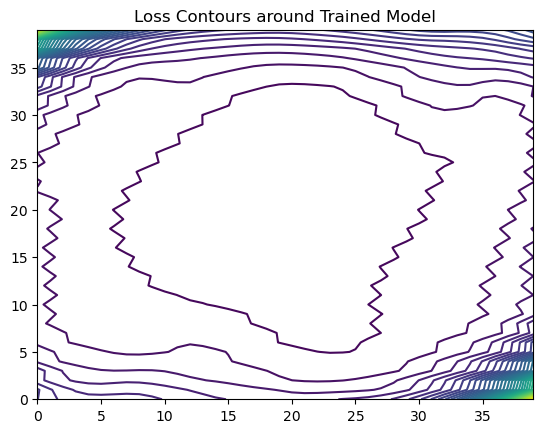

In [75]:
plt.contour(loss_data_fin, levels=50)
plt.title('Loss Contours around Trained Model')
plt.show()

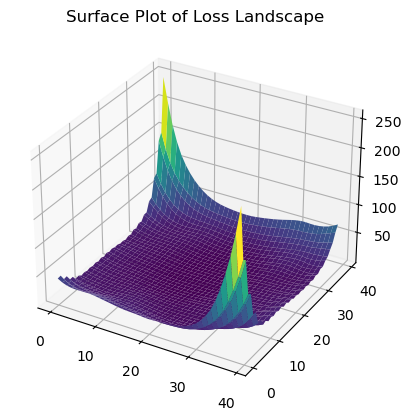

In [76]:
fig = plt.figure()
ax = plt.axes(projection='3d')
X = np.array([[j for j in range(STEPS)] for i in range(STEPS)])
Y = np.array([[i for _ in range(STEPS)] for i in range(STEPS)])
ax.plot_surface(X, Y, loss_data_fin, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
ax.set_title('Surface Plot of Loss Landscape')
fig.show()